# data_d25a.ipynb
1. Produce the fusion, high-end, low-end, and central projections.
2. Save tide gauge information.
3. Identify large cities with a tide gauge nearby.

Author: Benjamin S. Grandey.

In [1]:
import d25a
import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Get start datetime
start_dt = datetime.datetime.now()

In [3]:
# Print package versions
print(d25a.get_watermark())

Python implementation: CPython
Python version       : 3.10.16
IPython version      : 8.31.0

matplotlib: 3.10.0
numpy     : 2.2.1
pandas    : 2.2.3
seaborn   : 0.13.2
xarray    : 2025.1.1

conda environment: d25a-rsl-fusion

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 22.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



## Check that fusion results look reasonable

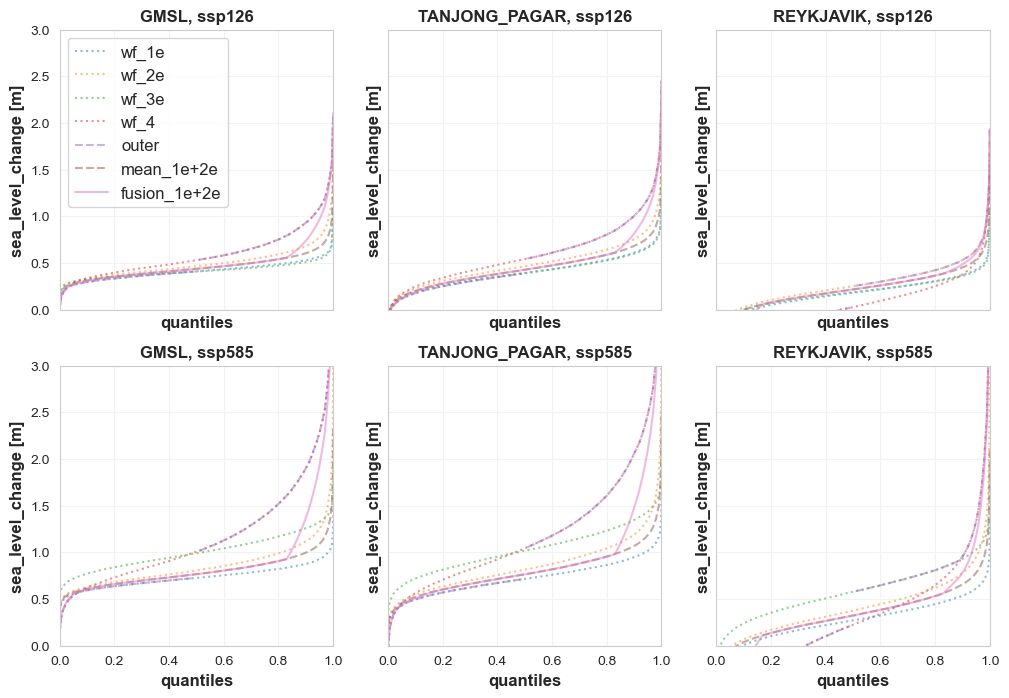

In [4]:
# Create subplot panels
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
# Loop over locations, scenarios, and corresponding axes
for g, gauge in enumerate([None, 'TANJONG_PAGAR', 'REYKJAVIK']):
    for s, scenario in enumerate(['ssp126', 'ssp585']):
        ax = axs[s, g]
        # Loop over workflows
        for workflow in ['wf_1e', 'wf_2e', 'wf_3e', 'wf_4', 'outer', 'mean_1e+2e', 'fusion_1e+2e']:
            # Get data for 2100
            if gauge:  # RSL
                qfs_da = d25a.get_sl_qfs(workflow=workflow, gmsl_rsl_novlm='rsl', scenario=scenario).sel(years=2100)
                qfs_da = qfs_da.sel(locations=d25a.get_gauge_info(gauge=gauge)['gauge_id'])
            else:  # GMSL
                qfs_da = d25a.get_sl_qfs(workflow=workflow, gmsl_rsl_novlm='gmsl', scenario=scenario).sel(years=2100)
            # Plot data
            if 'wf' in workflow:
                linestyle = ':'
            elif workflow == 'fusion_1e+2e':
                linestyle = '-'
            else:
                linestyle = '--'
            qfs_da.plot(ax=ax, linestyle=linestyle, alpha=0.5, label=workflow)
            # Customize title etc
            if gauge:
                ax.set_title(f'{gauge}, {scenario}')
            else:
                ax.set_title(f'GMSL, {scenario}')
            if g == 0 and s == 0:
                ax.legend()
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 3)

## Save fusion, high-end, and low-end projections

In [5]:
# Make output directory if it doesn't exist
if not d25a.DATA_DIR.exists():
    d25a.DATA_DIR.mkdir()

In [6]:
# Loop over GMSL/RSL and scenarios
for gmsl_rsl_novlm in ('gmsl', 'rsl', 'novlm'):
    for scenario in ['ssp585', 'ssp126']:
        # Derive fusion projection
        qfs_da = d25a.get_sl_qfs(workflow='fusion_1e+2e', gmsl_rsl_novlm=gmsl_rsl_novlm, scenario=scenario)
        # Drop locations with NaN
        if gmsl_rsl_novlm != 'gmsl':
            qfs_da = qfs_da.dropna(dim='locations')
        # Save fusion projection
        out_fn = d25a.DATA_DIR / f'{gmsl_rsl_novlm}_fusion_{scenario}_d25a.nc'
        print(f'Writing {out_fn.name}')
        qfs_da.to_netcdf(out_fn)
        # Derive and save high-end or low-end projection, depending on scenario
        if scenario == 'ssp585':
            high_da = qfs_da.sel(quantiles=0.95).squeeze()
            out_fn = d25a.DATA_DIR / f'{gmsl_rsl_novlm}_high_d25a.nc'
            print(f'Writing {out_fn.name}')
            high_da.to_netcdf(out_fn)
        elif scenario == 'ssp126':
            low_da = qfs_da.sel(quantiles=0.05).squeeze()
            out_fn = d25a.DATA_DIR / f'{gmsl_rsl_novlm}_low_d25a.nc'
            print(f'Writing {out_fn.name}')
            low_da.to_netcdf(out_fn)


Writing gmsl_fusion_ssp585_d25a.nc
Writing gmsl_high_d25a.nc
Writing gmsl_fusion_ssp126_d25a.nc
Writing gmsl_low_d25a.nc
Writing rsl_fusion_ssp585_d25a.nc
Writing rsl_high_d25a.nc
Writing rsl_fusion_ssp126_d25a.nc
Writing rsl_low_d25a.nc
Writing novlm_fusion_ssp585_d25a.nc
Writing novlm_high_d25a.nc
Writing novlm_fusion_ssp126_d25a.nc
Writing novlm_low_d25a.nc


## Save central projection
Defined as median of medium confidence mean under SSP2-4.5.

In [7]:
# Loop over GMSL/RSL and scenarios
for gmsl_rsl_novlm in ('gmsl', 'rsl', 'novlm'):
    # Derive medium confidence mean under SSP2-4.5
    qfs_da = d25a.get_sl_qfs(workflow='mean_1e+2e', gmsl_rsl_novlm=gmsl_rsl_novlm, scenario='ssp245')
    # Drop locations with NaN
    if gmsl_rsl_novlm != 'gmsl':
        qfs_da = qfs_da.dropna(dim='locations')
    # Derive and Save central projection
    central_da = qfs_da.sel(quantiles=0.5).squeeze()
    out_fn = d25a.DATA_DIR / f'{gmsl_rsl_novlm}_central_d25a.nc'
    print(f'Writing {out_fn.name}')
    central_da.to_netcdf(out_fn)

Writing gmsl_central_d25a.nc
Writing rsl_central_d25a.nc
Writing novlm_central_d25a.nc


## Save gauge information

In [8]:
# Create DataFrame to hold gauge information
gauge_info_df = pd.DataFrame(columns=['gauge_id', 'gauge_name', 'lat', 'lon', 'country'])
# Loop over locations for which projections are available
qfs_da = d25a.get_sl_qfs()
for location in qfs_da.locations.data:
    # Get information about this gauge and save to DataFrame
    gauge_info = d25a.get_gauge_info(location)
    gauge_info_df.loc[len(gauge_info_df)] = gauge_info
# Index by gauge_id
gauge_info_df = gauge_info_df.set_index('gauge_id')
# Save to CSV
out_fn = d25a.DATA_DIR / f'gauge_info_d25a.csv'
print(f'Writing {out_fn.name}')
gauge_info_df.to_csv(out_fn)

Writing gauge_info_d25a.csv


## Identify large cities with a tide gauge nearby
1. Urban agglomeration has a population greater than 5 million in 2025.
2. Select nearest tide gauge within a maximum distance of 100 km.

In [9]:
# Read World Urbanisation Prospects 2018 data
cities_df = pd.read_excel('data_wup18/WUP2018-F12-Cities_Over_300K.xls', header=16,
                          index_col=0, usecols='A:E,G,H,X')
# Select cities with population > 5 million (ie > 5000 thousand) in 2025
cities_df = cities_df.where(cities_df[2025] > 5000).dropna().sort_values(by=2025, ascending=False)
print(f'{len(cities_df)} cities have a population > 5 million in 2025.')
# Loop over these cities and find nearest tide gauge and distance
for index, row_ser in cities_df.iterrows():
    lat0 = row_ser['Latitude']  # latitude of city
    lon0 = row_ser['Longitude']  # longitude of city
    temp_df = gauge_info_df.copy()  # copy tide gauge data
    temp_df['distance'] = 6378 * np.arccos(  # calculate great-circle distance between city and all available gauges
        np.sin(np.radians(lat0)) * np.sin(np.radians(temp_df['lat'])) +
        np.cos(np.radians(lat0)) * np.cos(np.radians(temp_df['lat'])) * np.cos(np.radians(temp_df['lon'] - lon0)))
    temp_df['distance'] = temp_df['distance'].round(0).astype(int)  # round to nearest km
    temp_df = temp_df.sort_values(by=['distance']).reset_index()  # sort by distance
    for col in ['gauge_id', 'gauge_name', 'lat', 'lon', 'distance']:
        cities_df.loc[index, col] = temp_df.loc[0, col]  # save gauge info to cities_df
# Keep only cities with distance <= 100 km
cities_df = cities_df.where(cities_df['distance'] <= 100).dropna()
print(f'{len(cities_df)} are within 100 km of a tide gauge.')
# Save to CSV
out_fn = d25a.DATA_DIR / f'cities_d25a.csv'
print(f'Writing {out_fn.name}')
cities_df.to_csv(out_fn)

95 cities have a population > 5 million in 2025.
38 are within 100 km of a tide gauge.
Writing cities_d25a.csv


In [10]:
# Get end datetime
end_dt = datetime.datetime.now()
# Calculate run timedelta
run_td = end_dt - start_dt
# Print timing information
print(f"Start:     {start_dt.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"End:       {end_dt.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Wall time: {run_td.seconds} s")

Start:     2025-01-17 16:24:23
End:       2025-01-17 16:24:54
Wall time: 31 s
